## Элементарные методы анализа временных рядов

In [145]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

<Figure size 1008x576 with 0 Axes>

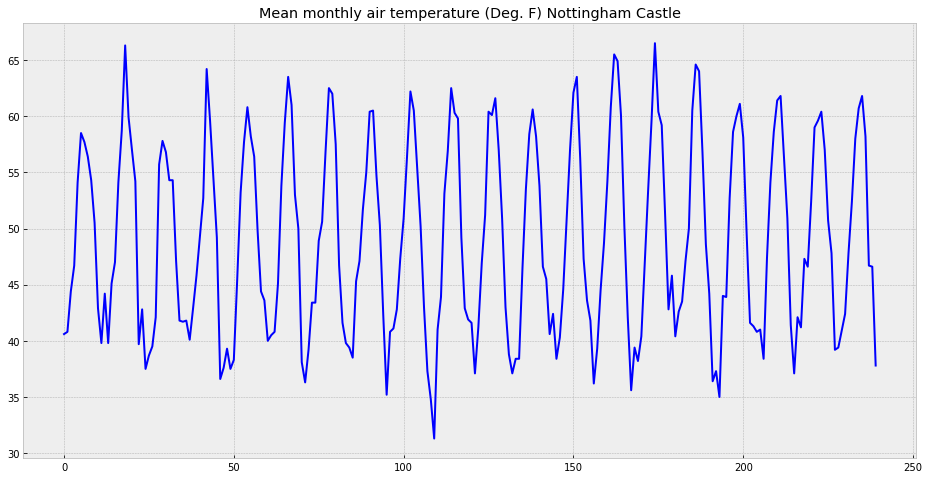

In [3]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.figure(figsize=(16, 8))
    plt.plot(mean_monthly_temp['Deg'], color='blue')
    plt.title('Mean monthly air temperature (Deg. F) Nottingham Castle')

#### Выберем метод Хольта-Винтерса т.к. на наших временных рядах нужно учитывать сезонность

In [11]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [5]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [14]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [70]:
def plot_tema(alpha, beta, gamma, ser=mean_monthly_temp['Deg'], ser_to_plot=mean_monthly_temp['Deg'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot,linewidth='1', color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='predict')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha.round(5), beta.round(5), gamma.round(5)))
        plt.legend()

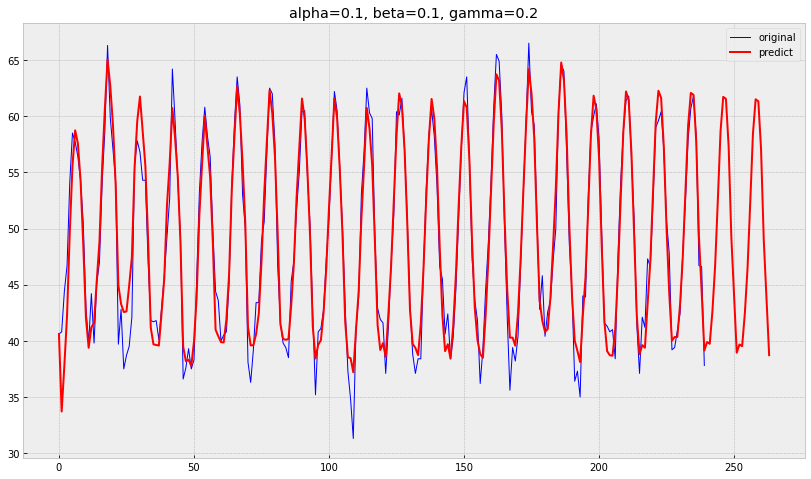

In [23]:
plot_tema(0.1, 0.1, 0.2)

In [93]:
train, val = mean_monthly_temp['Deg'][:150], mean_monthly_temp['Deg'][150:]

In [175]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}')
    return np.mean(np.array(errors))

In [95]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

37.630171230259116
36.25712639428098
37.630171230259116
37.513489216059334
36.64598192775543
36.001122684509006
35.23286250829748
34.66820193020972
33.395973896078445
33.30019980004968
31.7821854434796
30.995207097056717
28.895404046290025
28.006436812158086
25.35642876884899
24.616901739664883
21.670269814965874
20.806367633396068
18.16981281915113
16.966288011138275
14.623178959427563
14.22243366919897
13.293164037357904
14.219261862629734
14.577896891756195
19.64329924657399
13.370182330461212
15.775425973714817
13.67886937934098
12.664728234303332
12.314099516401157
14.121206177691848
13.065496079615542
12.253544041926318
11.789988877875409
11.338613117310127
10.529874634836828
10.35521109332908
9.698064969382775
9.039338182174225
8.076647028652308
8.146346775246522
7.889655148094843
8.380963868055877
7.292299089441467
7.365413908054921
7.108058837408297
6.854925010653978
8.038278624029642
7.52393515002291
6.813801027336442
6.617757486815239
6.557601885879866
7.083124137389902
6.50

In [77]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[ 0.0320519 , -0.00367093,  0.19194061],
       [ 0.03204296, -0.00367219,  0.19202747],
       [ 0.03204622, -0.00367239,  0.19199198],
       [ 0.03205438, -0.00367189,  0.19198956]]), array([6.35165367, 6.35165368, 6.35165368, 6.35165369]))
           fun: 6.35165366882395
       message: 'Optimization terminated successfully.'
          nfev: 219
           nit: 121
        status: 0
       success: True
             x: array([ 0.0320519 , -0.00367093,  0.19194061])


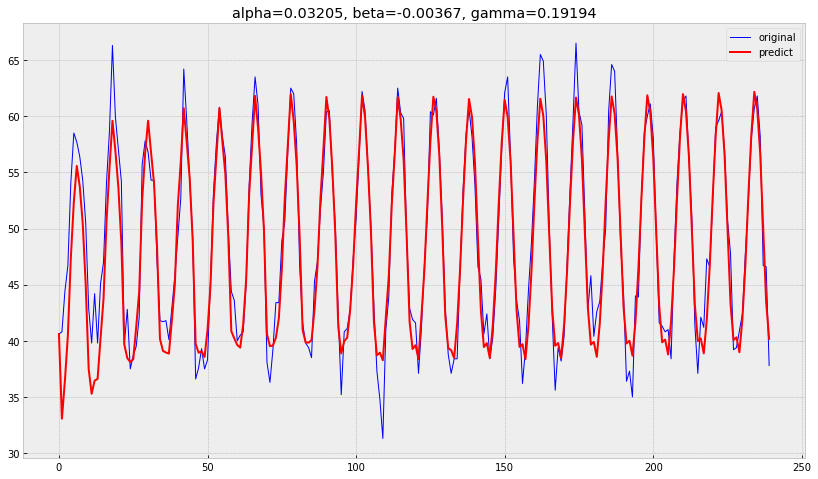

In [78]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=mean_monthly_temp['Deg'], n_preds=len(val))

### Выберем теперь не станционарный ряд, индекс доу джонса

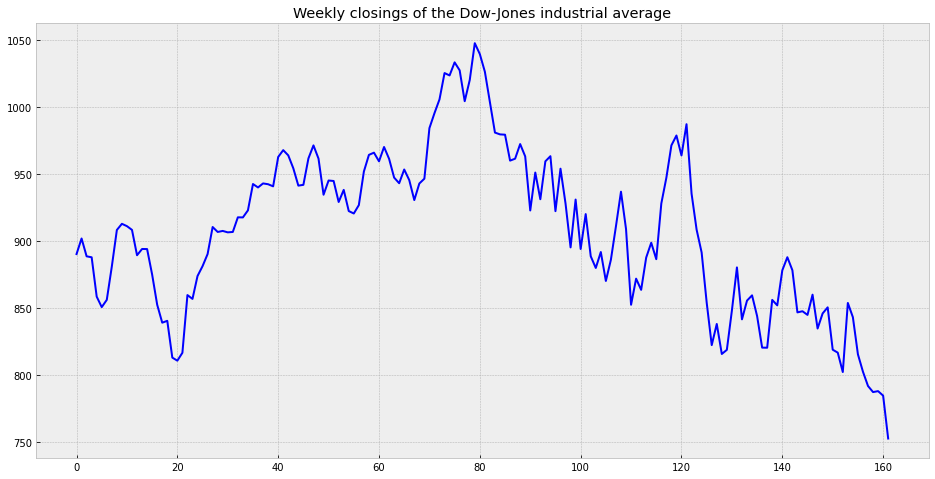

In [21]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    plt.plot(dowjones_closing['Close'], color='blue')
    plt.title('Weekly closings of the Dow-Jones industrial average')

In [79]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [99]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', title=''):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

#### Приведем к станционарному виду

Results of Dickey-Fuller Test:
Test Statistic                -5.734289e+00
p-value                        6.492178e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64


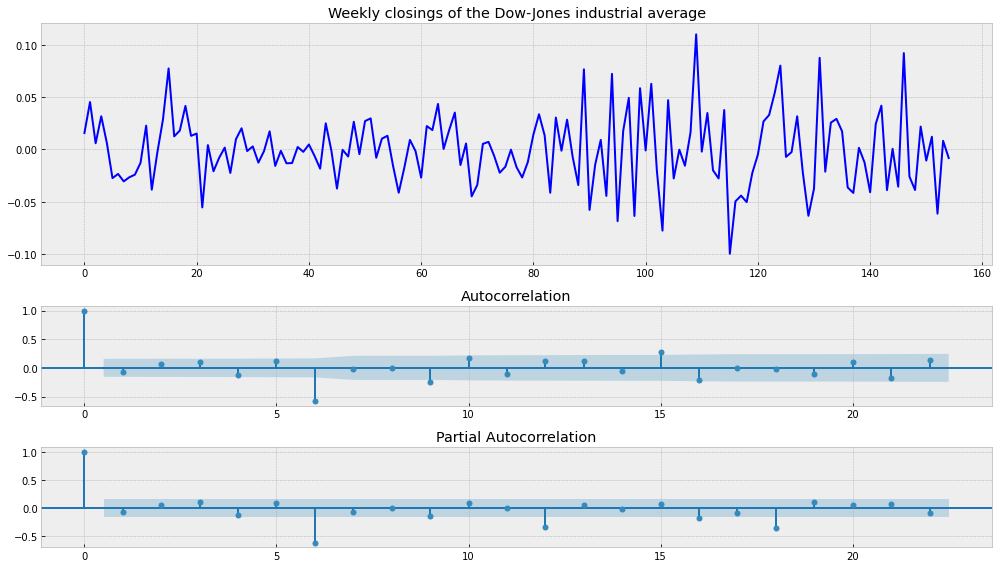

In [84]:
dowjones = boxcox(dowjones_closing['Close'], 0)
dowjones = dowjones[1:] - dowjones[:-1]
dowjones = dowjones[6:] - dowjones[:-6]
tsplot(dowjones, title='Weekly closings of the Dow-Jones industrial average')

In [152]:
train_stat, val_stat = pd.Series(dowjones[:100]), pd.Series(dowjones[100:])
train, val = dowjones_closing['Close'][:100], dowjones_closing['Close'][100:]

In [191]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_stat):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 6, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
#     print(f'{np.mean(np.array(errors))}')
    return np.mean(np.array(errors))

In [192]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

In [193]:
alpha_opt, beta_opt, gamma_opt = opt.x

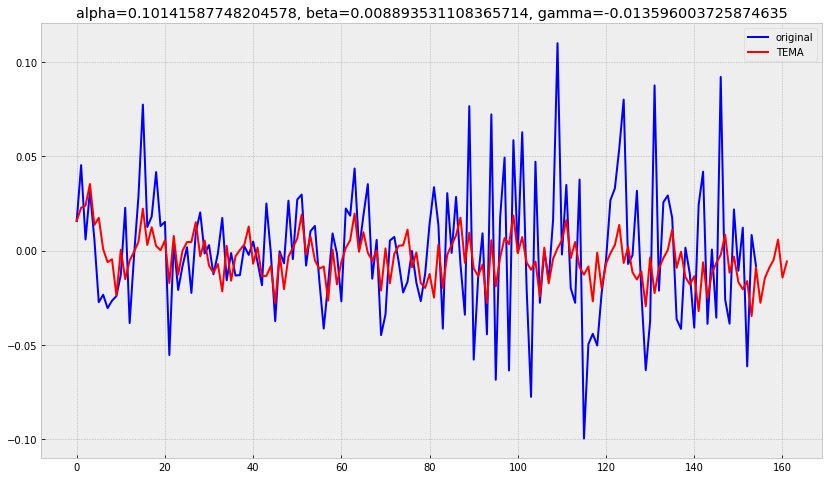

In [195]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train_stat, ser_to_plot=dowjones, n_preds=len(val))

#### Подобранные параметры вручную

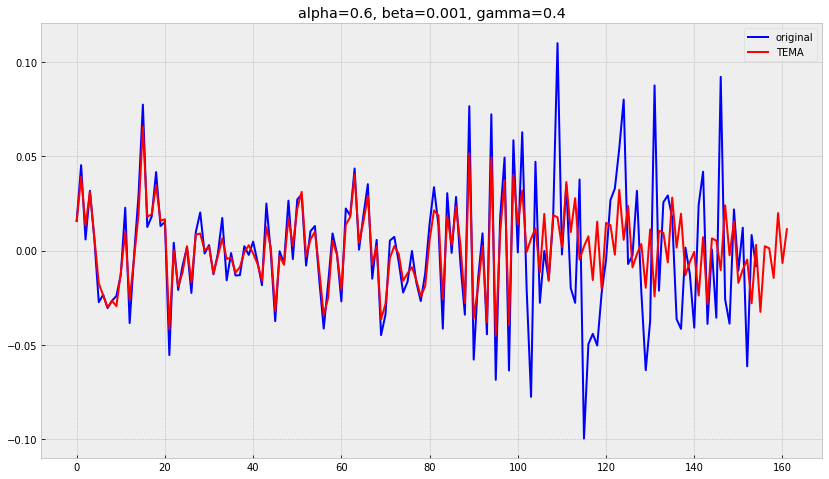

In [217]:
plot_tema(0.6, 0.001, 0.4, ser=train_stat, ser_to_plot=dowjones, n_preds=len(val))

Данный ряд трудно предсказать, т.к. происходит колебание цены  